## scVI data integration for healthy PBMC pilot study (Cai 2020 and Cai 2022)

**Objective**: Run scVI data integration model for TB PBMCs [Cai 2020 and Cai 2022] with healthy control [Yoshida 2021]


- **Developed by**: Mairi McClean

- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**

- v230710

- Following this tutorial:https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html



### Import modules and set working environment

In [1]:
import scanpy as sc
import scvi
from rich import print
from scib_metrics.benchmark import Benchmarker

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 30
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 30


### Read in data
> Cai 2020 + Cai 2022 TB data

- Read in _Cai Y et al 2020_

In [3]:
caiy2020 = sc.read_h5ad('/Volumes/Expansion/data_lake/processed_files/qc_objects/human/cai2020/cai2020_scrna_PBMC_mm_230306_qcd.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 72935 × 36039
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'status_colors'
    layers: 'counts', 'sqrt_norm'

In [4]:
caiy2020.obs['status'].value_counts()

status
active_TB    32923
Healthy      22036
latent_TB    17976
Name: count, dtype: int64

- Read in _Cai Y et al 2022_

In [5]:
caiy2022 = sc.read_h5ad('/Volumes/Expansion/data_lake/processed_files/qc_objects/human/cai2022/Cai2022_scrna_PBMC_mm_230306_qcd.h5ad')
caiy2022.obs['status'] = 'TPE'
caiy2022

AnnData object with n_obs × n_vars = 23979 × 31155
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets', 'status'
    var: 'gene_id', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [6]:
caiy2022.obs['status'].value_counts()

status
TPE    23979
Name: count, dtype: int64

- Concatenate query datasets

In [7]:
adata_tb = caiy2020.concatenate(caiy2022, batch_key = 'dataset', batch_categories = ['cai2020', 'cai2022'], join = 'inner')
adata_tb

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 96914 × 28831
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells-cai2020', 'n_cells_by_counts-cai2020', 'mean_counts-cai2020', 'pct_dropout_by_counts-cai2020', 'total_counts-cai2020', 'n_cells-cai2022', 'n_cells_by_counts-cai2022', 'mean_counts-cai2022', 'pct_dropout_by_counts-cai2022', 'total_counts-cai2022'
    layers: 'counts', 'sqrt_norm'

In [8]:
adata_tb.obs['seed_labels'] = 'Unknown'

#### Read in reference data

- Yoshida 2021

In [9]:
yoshida2021 = sc.read_h5ad('/Volumes/Expansion/data_lake/processed_files/qc_objects/human/yoshida2021/Yoshida2021_scrna_PBMC_mm_230306_qcd.h5ad')
yoshida2021

AnnData object with n_obs × n_vars = 173684 × 22886
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'name', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'COVID_status_colors', 'sample_id_colors'
    layers: 'counts', 'sqrt_norm'

In [10]:
yoshida2021.obs['seed_labels'] = yoshida2021.obs['annotation_broad'].copy()
del(yoshida2021.obs['annotation_broad'])
yoshida2021

AnnData object with n_obs × n_vars = 173684 × 22886
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets', 'seed_labels'
    var: 'name', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'COVID_status_colors', 'sample_id_colors'
    layers: 'counts', 'sqrt_norm'

In [11]:
yoshida2021.obs['seed_labels'].value_counts()

seed_labels
T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: count, dtype: int64

#### Relabel columns to ease concatenation


In [12]:
yoshida2021.obs.rename(columns={"patient_id": "donor"}, inplace=True)
yoshida2021.obs.rename(columns={"COVID_status": "status"}, inplace=True)
yoshida2021.obs.rename(columns={"Sex": "gender"}, inplace=True)
yoshida2021.obs.rename(columns={"Age_group": "age"}, inplace=True)
yoshida2021.obs['tissue'] = 'PBMC'
yoshida2021.obs

orig.ident   
index                                                                                   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  CV001_KM10202384-CV001_KM10202394  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  CV001_KM10202384-CV001_KM10202394   
...                                                                               ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1    CV001_KM9166642-CV001_KM9166650   

                                                    nCount_RNA  nFeature_RNA   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5493.0          1767  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      4868.0          1577   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      3178.0          1257   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      4745.0          1477   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1902.0           954   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1      3513.0          1297   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1      1888.0          1296   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      1798.0           814   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      4407.0          1351   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1      2676.0          1297   

                                                    nCount_ADT  nFeature_ADT   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5297.0           184  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      2169.0           165   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      1330.0           163   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      1255.0           161   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1711.0           166   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1       513.0           137   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1       631.0           145   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      2227.0           169   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      1014.0           153   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1       779.0           138   

                                                           age      BMI   
index                                                                     
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Adult  Unknown  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...       Adult  Unknown   
...                                                        ...      ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1       Child     18.2   
CV001_KM91

In [13]:
yoshida2021.obs['status'].value_counts()

status
Healthy    173684
Name: count, dtype: int64

### Merge datasets

In [14]:
adata = yoshida2021.concatenate(adata_tb, batch_key = 'dataset', batch_categories = ['reference', 'query'], join = 'inner')
adata

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 270598 × 15808
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'age', 'BMI', 'COVID_severity', 'status', 'Ethnicity', 'Group', 'gender', 'Smoker', 'annotation_detailed', 'annotation_detailed_fullNames', 'donor', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets', 'seed_labels', 'tissue', 'study', 'individual', 'sample', 'data_type', 'centre', 'version', 'batch', 'object', 'protocol', 'dataset'
    var: 'mt', 'ribo', 'hb', 'gene_id-query', 'n_cells-cai2020-query', 'n_cells_by_counts-cai2020-query', 'mean_counts-cai2020-query', 'pct_dropout_by_counts-cai2020-query', 'total_counts-cai2020-query', 'n_cells-cai2022-query', 'n_cells_by_counts-cai2022-

### Format object and check for downstream analysis

- Remove unrequired columns

In [15]:
adata.obs = adata.obs.drop(columns=['age', 'gender', 'data_type', 'centre', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'S_score', 'version', 'batch', 'Ethnicity', 'Group', 'sequencing_library', 'Protein_modality_weight', 
'individual', 'sample', 'COVID_severity', 'Smoker', 'BMI', 'nFeature_ADT', 'nCount_ADT', 'nFeature_RNA', 'nCount_RNA', 'orig.ident', 'G2M_score', 'predicted_doublets', 'total_counts_mt', 'total_counts', 'n_genes_by_counts', 'n_genes'])

In [16]:
adata.obs['study'] = adata.obs['study'].cat.add_categories("Yoshida_2021").fillna("Yoshida_2021")

- Check label harmonisation

In [17]:
adata.obs

status   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  Healthy  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  Healthy   
...                                                     ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-cai202...      TPE   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-cai202...      TPE   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-cai202...      TPE   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-cai202...      TPE   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-cai202...      TPE   

                                                   annotation_detailed   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Monocyte CD14  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...         T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...         T CD4 naive   
...                                                                ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-cai202...                 NaN   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-cai202...                 NaN   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-cai202...                 NaN   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-cai202...                 NaN   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-cai202...                 NaN   

                                                   annotation_detailed_fullNames   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...            Classical monocyte  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...                   T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...                   T CD4 naive   
...                                                                          ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-cai202...                           NaN   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-cai202...                           NaN   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-cai202...                           NaN   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-cai202...                           NaN   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-cai202...                           NaN   

                                                   donor sample_id   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...   AN5       AN5  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...   AN5       AN5   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...   AN3       AN3   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...   AN5       AN5   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...   AN5       AN5   
...                                                  ...       ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-cai202...    P4       NaN   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-cai202...    P4       NaN   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-cai202...    P4       NaN   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-cai202...    P4       NaN   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-cai202...    P4       NaN   

                                                    total_counts_hb   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...              2.0  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...              0.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...              0.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...              0.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...              0.0   
...                                                             ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-cai202...          

In [18]:
adata.obs = adata.obs.drop(columns=['annotation_detailed', 'annotation_detailed_fullNames', 'sample_id'])

In [19]:
adata.obs = adata.obs.drop(columns=['object', 'protocol'])

In [20]:
adata.obs['study'].value_counts()

study
Yoshida_2021    173684
CaiY_2021        72935
CaiY_2022        23979
Name: count, dtype: int64

In [21]:
adata.obs['tissue'].value_counts()

tissue
PBMC    270598
Name: count, dtype: int64

In [22]:
adata.obs['status'].value_counts()

status
Healthy      195720
active_TB     32923
TPE           23979
latent_TB     17976
Name: count, dtype: int64

In [23]:
adata.obs['donor'].value_counts()

donor
SAMN14048023    11395
SAMN14048019    11271
SAMN14048025    11150
SAMN14048020    10765
SAMN14048024    10378
SAMN14048022     9836
NP18             9799
NP13             8945
AN13             8244
SAMN14048021     8140
NP23             8038
P1               7856
NP24             7376
AN12             7219
AN7              7105
NP19             7050
NP28             6894
P4               6676
NP17             6377
NP39             6115
AN2              5973
NP44             5906
NP36             5891
NP22             5535
NP27             5300
NP31             5029
P3               5025
NP21             4833
NP37             4654
AN6              4296
AN9              4150
AN5              3943
NP30             3916
NP41             3898
NP32             3778
NP15             3701
NP26             3539
NP20             3374
NP38             3218
P5               2393
AN14             2260
P6               2029
NP16             1851
AN11             1847
NP35             1674
AN3 

### Calculate HVGs

In [30]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)
adata

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 270598 × 7000
    obs: 'status', 'donor', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrX', 'doublet_scores', 'seed_labels', 'tissue', 'study', 'dataset'
    var: 'mt', 'ribo', 'hb', 'gene_id-query', 'n_cells-cai2020-query', 'n_cells_by_counts-cai2020-query', 'mean_counts-cai2020-query', 'pct_dropout_by_counts-cai2020-query', 'total_counts-cai2020-query', 'n_cells-cai2022-query', 'n_cells_by_counts-cai2022-query', 'mean_counts-cai2022-query', 'pct_dropout_by_counts-cai2022-query', 'total_counts-cai2022-query', 'name-reference', 'n_cells-reference', 'n_cells_by_counts-reference', 'mean_counts-reference', 'pct_dropout_by_counts-reference', 'total_counts-reference', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'sqrt_norm'

### Integration with scVI


In [31]:
adata.obs['study']=adata.obs['study'].astype(str)

In [32]:
adata.obs['donor']=adata.obs['donor'].astype(str)

In [42]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys = ['donor', 'study'], layer = 'counts')

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [36]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [43]:
scvi_vae = scvi.model.SCVI(adata, **arches_params, n_latent=50, gene_likelihood="nb")

In [44]:
scvi.model.SCVI.view_anndata_setup(scvi_vae)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['donor', 'study'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 270598 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  7000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │     AN1      │          0          │
│                    │     AN11     │          1          │
│                    │     AN12     │          2          │
│                    │     AN13     │          3          │
│                    │     AN14     │          4          │
│                    │     AN2      │          5          │
│                    │     AN3      │          6          │
│                    │     AN5      │          7          │
│                    │     AN6      │          8          │
│                    │     AN7      │          9          │
│                    │     AN9      │         10          │
│                    │     NP13     │         11          │
│                    │     NP15     │         12          │
│                    │     NP16     │         13          │
│                    │     NP17     │         14          │
│                    │     NP18     │         15          │
│                    │     NP19     │         16          │
│                    │     NP20     │         17          │
│                    │     NP21     │         18          │
│                    │     NP22     │         19          │
│                    │     NP23     │         20          │
│                    │     NP24     │         21          │
│                    │     NP26     │         22          │
│                    │     NP27     │         23          │
│                    │     NP28     │         24          │
│                    │     NP30     │         25          │
│                    │     NP31     │         26          │
│                    │     NP32     │         27          │
│                    │     NP35     │         28          │
│                    │     NP36     │         29          │
│                    │     NP37     │         30          │
│                    │     NP38     │         31          │
│                    │     NP39     │         32          │
│                    │     NP41     │         33          │
│                    │     NP44     │         34          │
│                    │      P1      │         35          │
│                    │      P3      │         36          │
│                    │      P4      │         37          │
│                    │      P5      │         38          │
│                    │      P6      │         39          │
│                    │ SAMN14048019 │         40          │
│                    │ SAMN14048020 │         41          │
│                    │ SAMN14048021 │         42          │
│                    │ SAMN14048022 │         43          │
│                    │ SAMN14048023 │         44          │
│                    │ SAMN14048024 │         45          │
│                    │ SAMN14048025 │         46          │
│                    │              │                     │
│ adata.obs['study'] │  CaiY_2021   │          0          │
│                    │  CaiY_2022   │          1          │
│                    │ Yoshida_2021 │          2          │
│                    │              │                     │
└────────────────────┴──────────────┴─────────────────────┘

In [45]:
scvi_vae.train()

Epoch 10/30:  30%|███       | 9/30 [10:41<24:55, 71.22s/it, loss=2.83e+03, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(



Epoch 30/30: 100%|██████████| 30/30 [31:56<00:00, 64.55s/it, loss=2.8e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [31:56<00:00, 63.88s/it, loss=2.8e+03, v_num=1]


In [46]:
adata.obsm["X_scVI"] = scvi_vae.get_latent_representation()

In [51]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


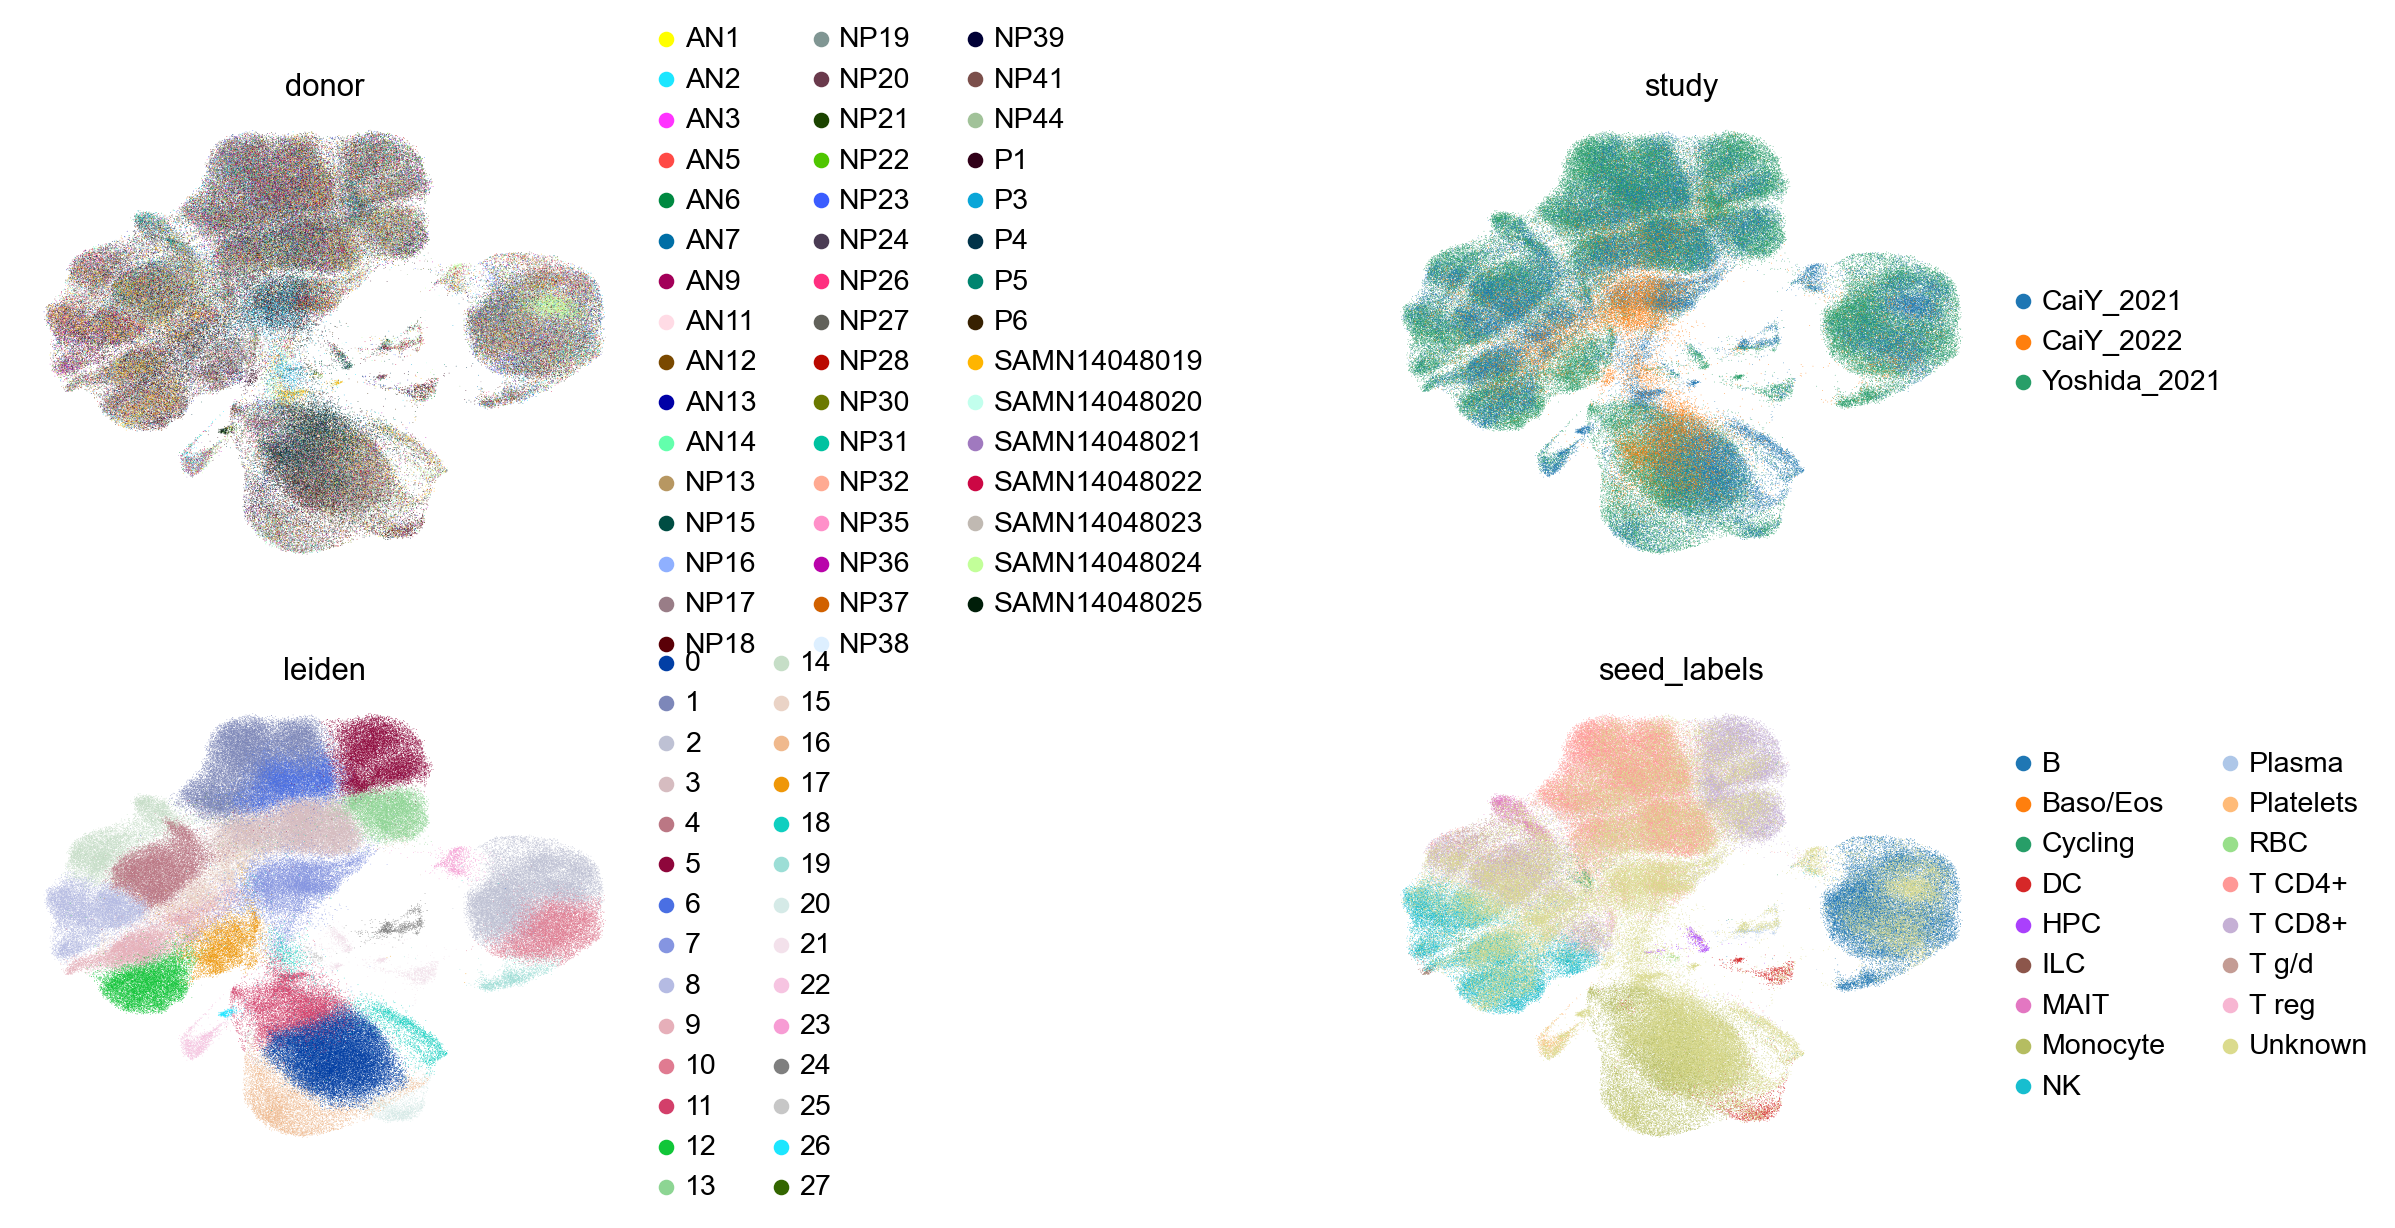

In [53]:
sc.pl.umap(
    adata,
    color=["donor", "study", "leiden", "seed_labels"],
    frameon=False,
    ncols=2,
    wspace=1
)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['status'], groups='TB_TPE', size = 0.8, legend_fontsize = 5)
sc.pl.umap(adata, frameon = False, color = ['status'], groups='Healthy', size = 0.8, legend_fontsize = 5)
sc.pl.umap(adata, frameon = False, color = ['status'], groups='active_TB', size = 0.8, legend_fontsize = 5)
sc.pl.umap(adata, frameon = False, color = ['status'], groups='latent_TB', size = 0.8, legend_fontsize = 5)

### Label transfer with scANVI

In [54]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_vae, unlabeled_category = 'Unknown', labels_key = 'seed_labels')

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [55]:
scanvi_model.train(max_epochs=25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 25/25: 100%|██████████| 25/25 [43:59<00:00, 106.41s/it, loss=2.93e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [43:59<00:00, 105.57s/it, loss=2.93e+03, v_num=1]


In [56]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Get latent representation

In [57]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation()

- Visualise

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


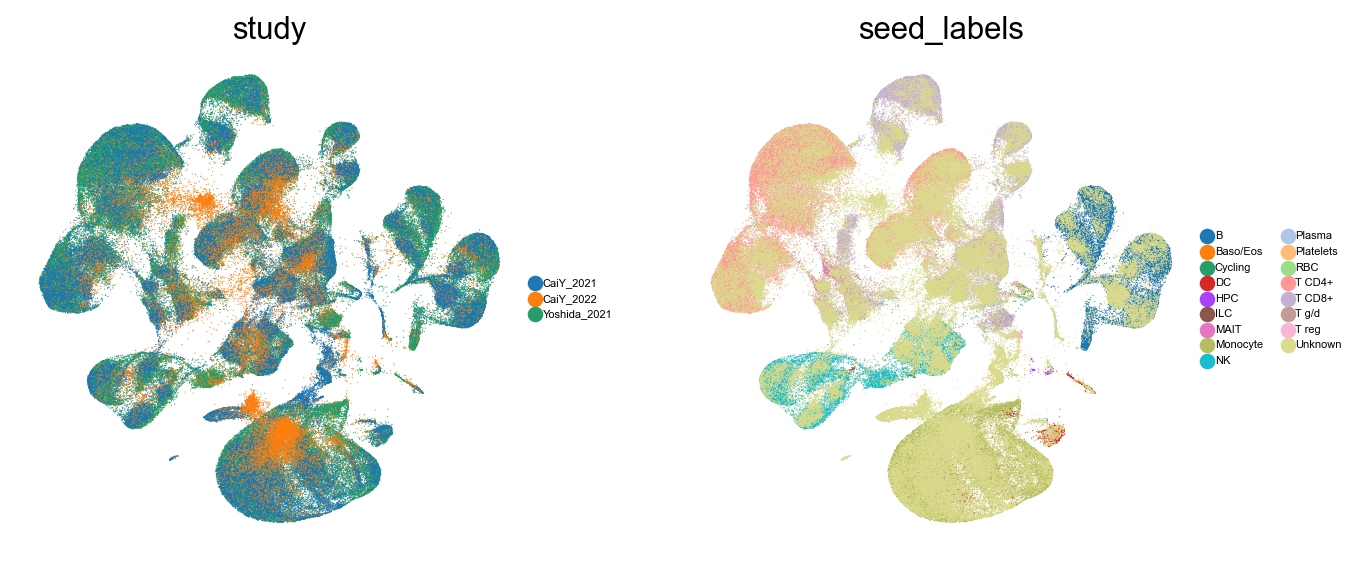

In [69]:
# Leiden clustering removed as will be optimized via SCCAF

sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['study', 'seed_labels'], size = 1, legend_fontsize = 5, ncols = 4)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


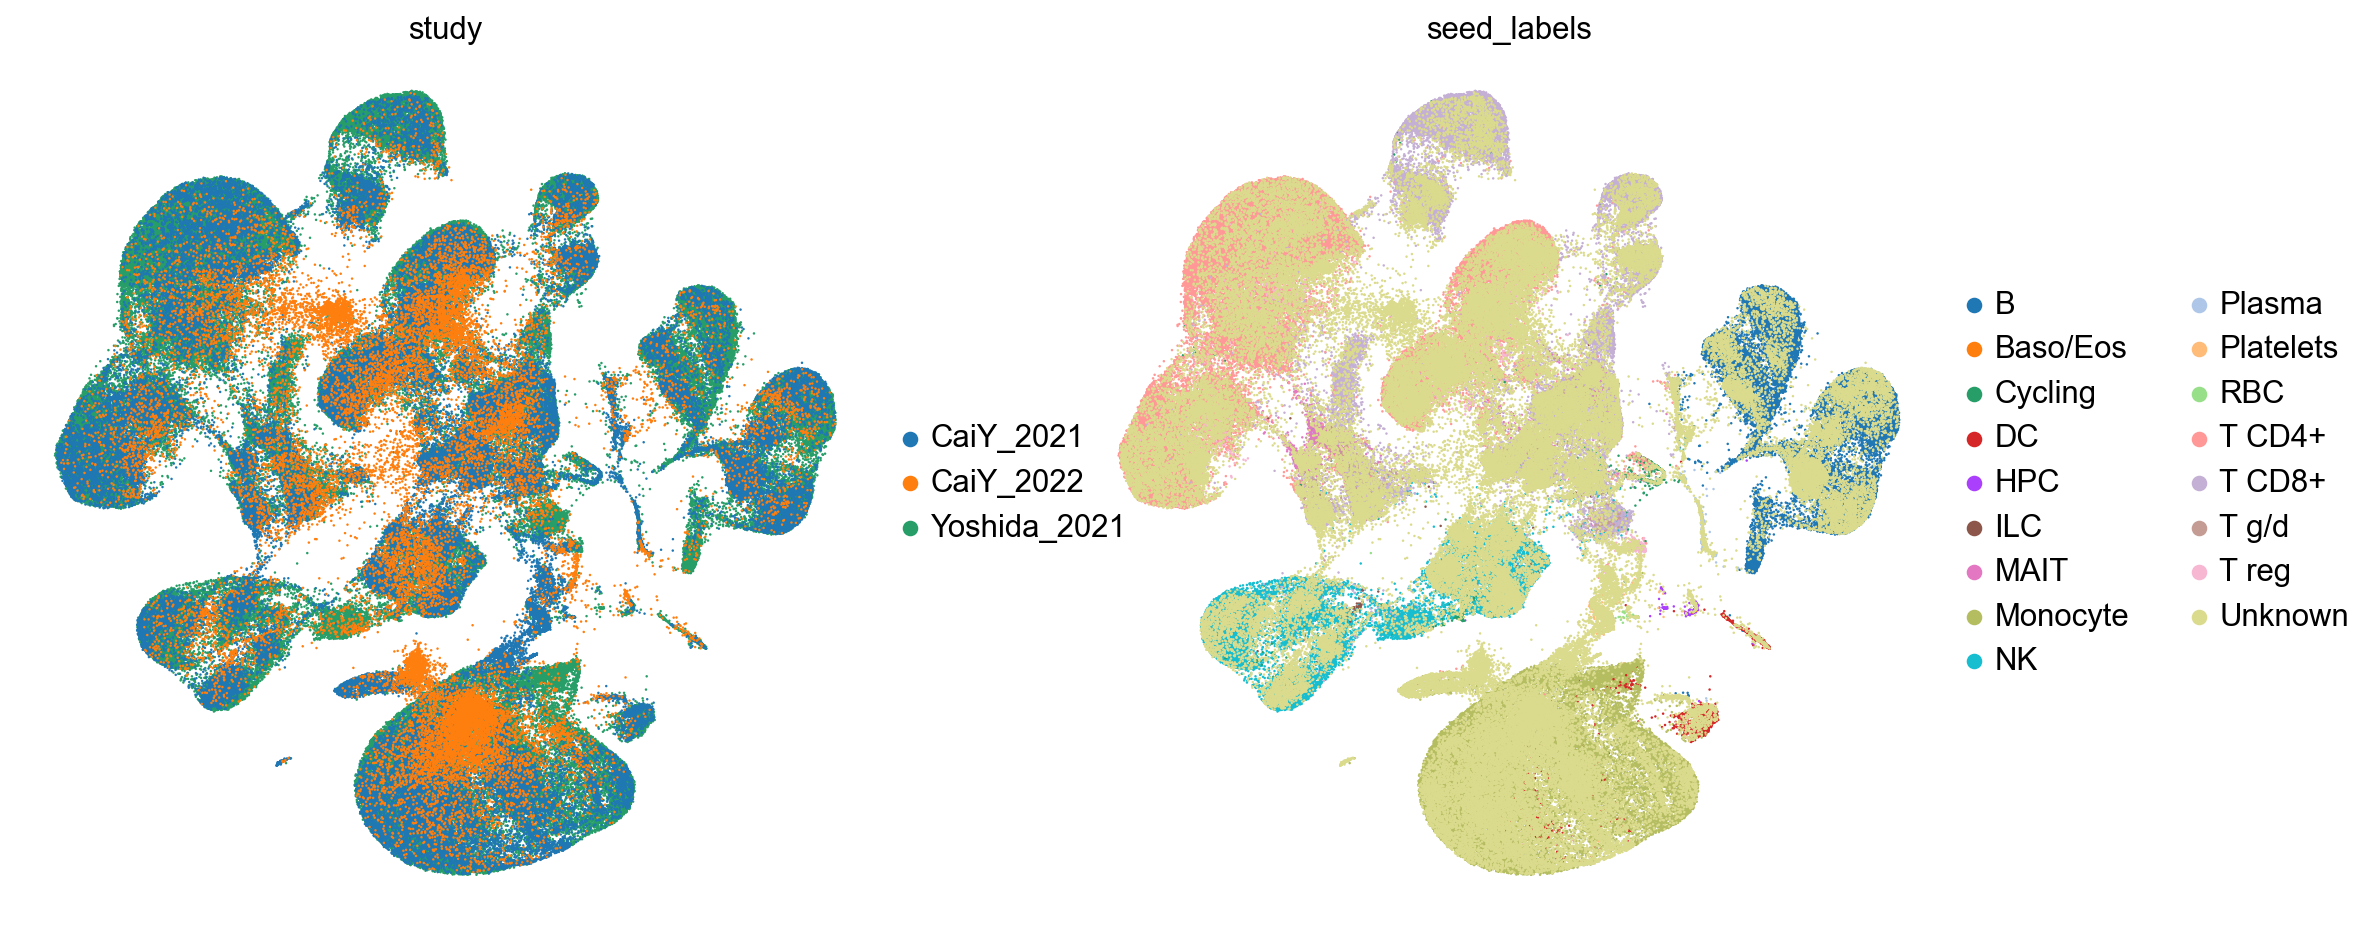

In [70]:
sc.set_figure_params(scanpy=True, figsize=(7, 7))
sc.pl.umap(adata, frameon = False, color = ['study', 'seed_labels'], size = 5, legend_fontsize = 14, ncols = 2)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


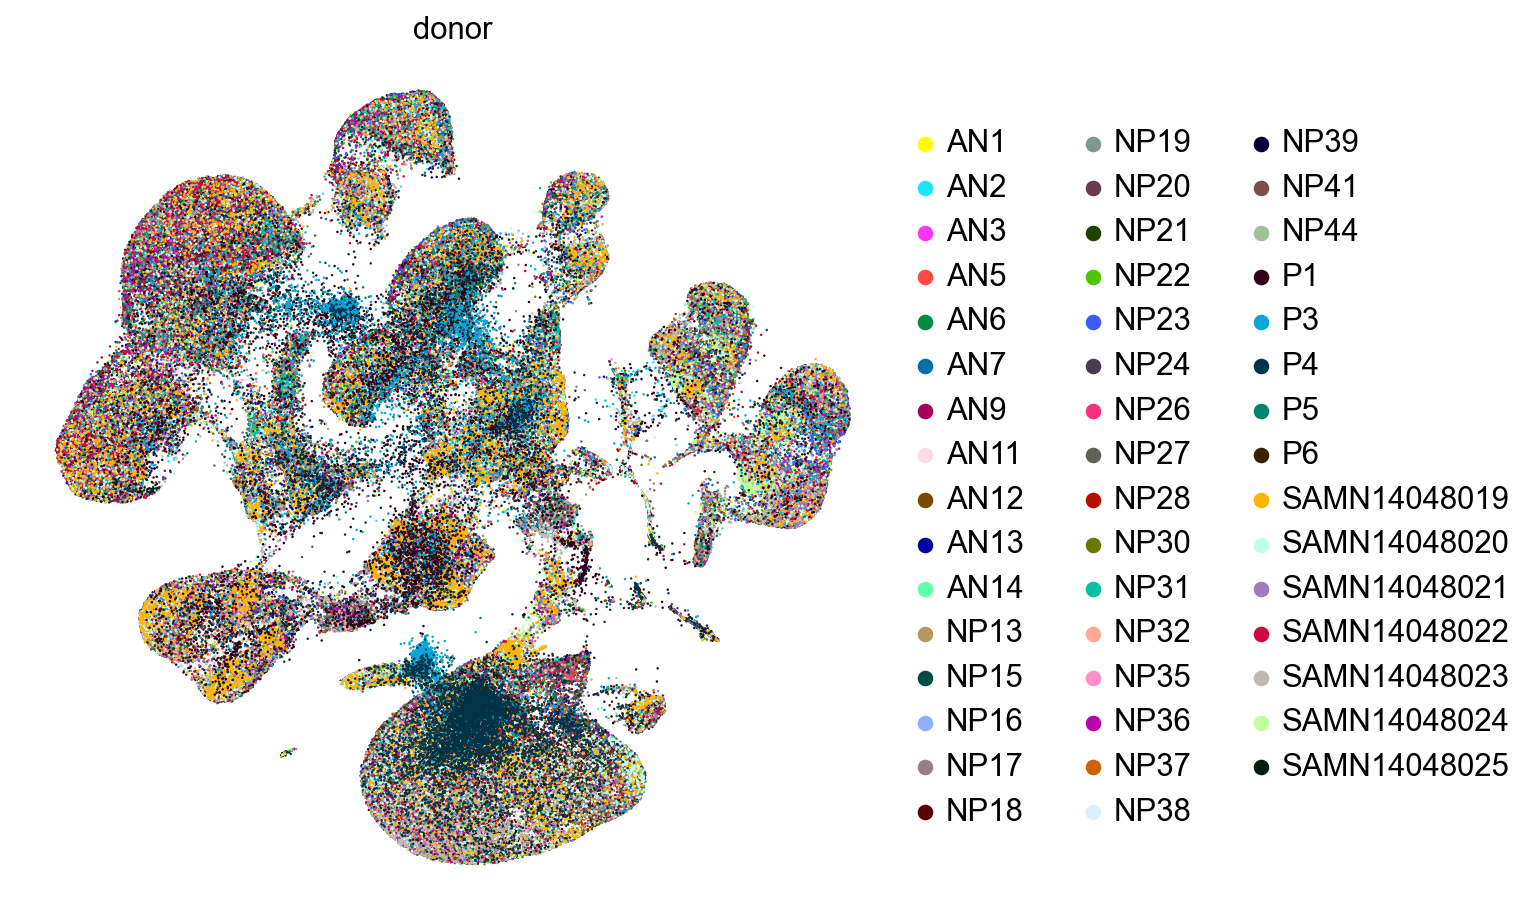

In [74]:
sc.set_figure_params(scanpy=True, figsize=(7, 7))
sc.pl.umap(adata, frameon = False, color = ['donor'], size = 5, legend_fontsize = 14, ncols = 2)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


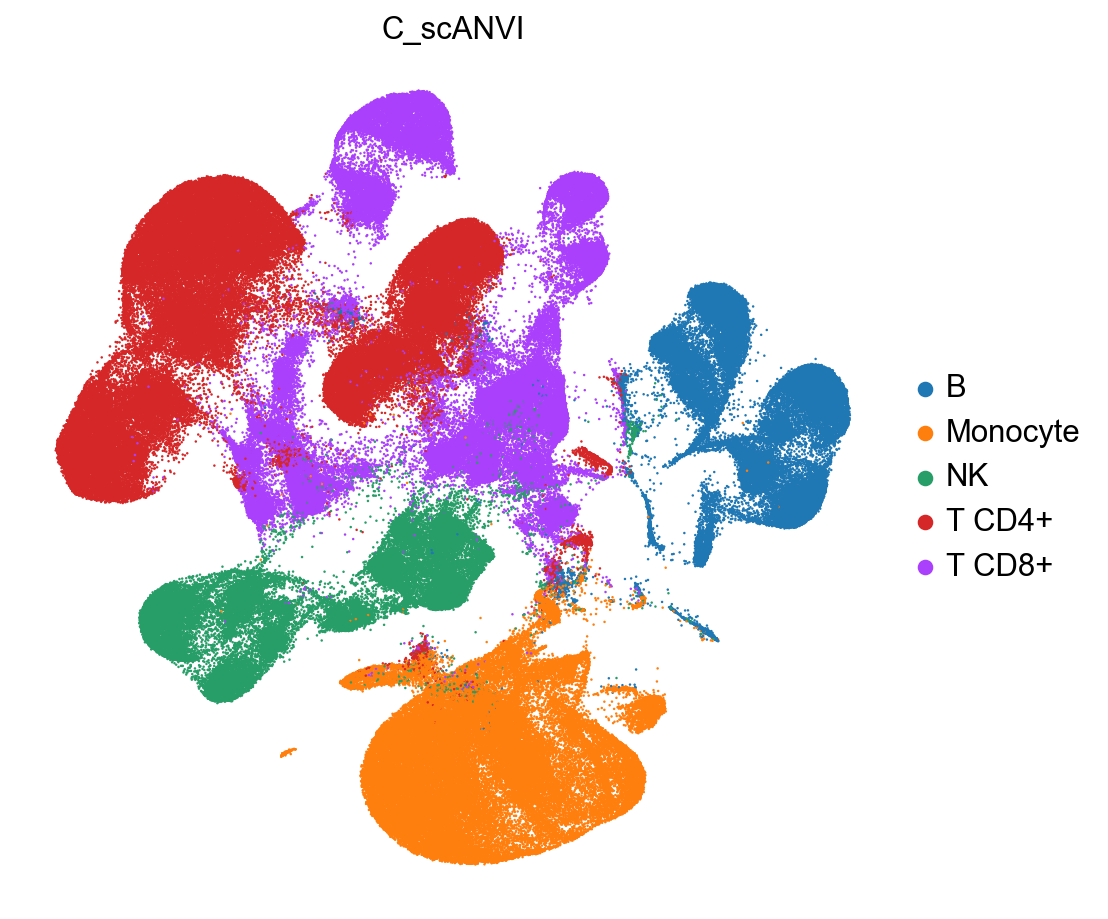

In [73]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI'], size = 5, legend_fontsize = 14, ncols = 2)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


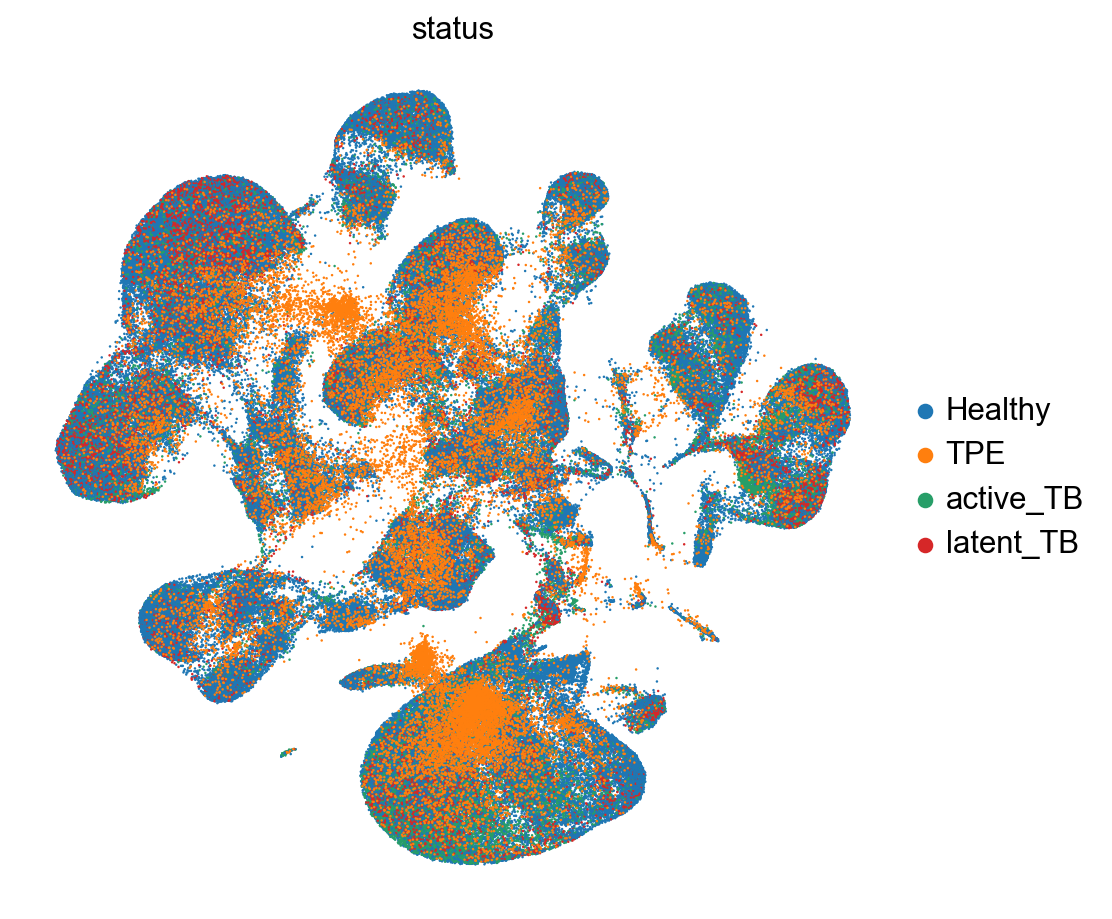

In [75]:
sc.pl.umap(adata, frameon = False, color = ['status'], size = 5, legend_fontsize = 14, ncols = 2)

### Compute integration metrics

In [ ]:
bm = Benchmarker(
    adata,
    batch_key = ["study", "donor"],
    label_key = "C_scANVI",
    embedding_obsm_keys = ["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object

adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export

In [ ]:
adata_export.write('/Volumes/Expansion/data_lake/processed_files/label_transfer/230710mm_TB_PBMC_scrna_Cai20_Cai22_Yoshida21_scANVI_annot.raw.h5ad')